# GradCAM - Gradient Class Activation Map

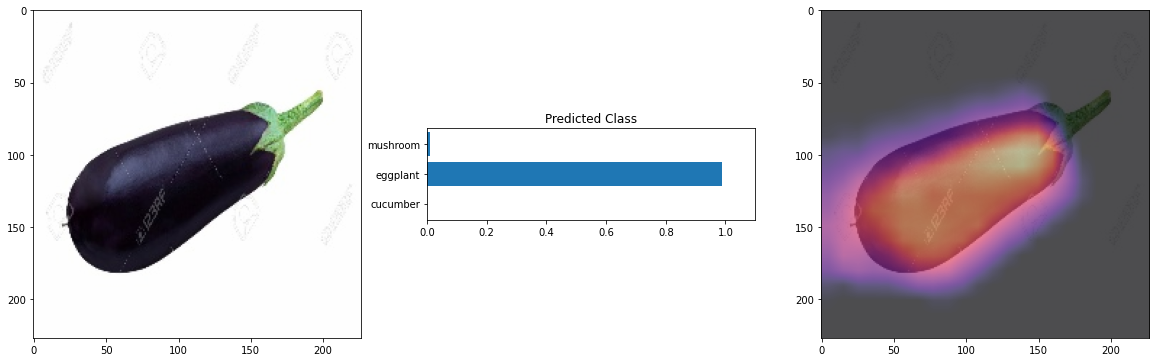

In [ ]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

fatal: destination path 'GradCAM-Dataset' already exists and is not an empty directory.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ny9geius
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ny9geius
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done


# Imports

In [ ]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [ ]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'

DEVICE = 'cuda'
BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [ ]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [ ]:
# cucumber - 0, eggplant - 1, mushroom - 2

train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = 42)

# Augmentations

In [ ]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p = 0.5),
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.255])
])

valid_augs = A.Compose([
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])


# Load Image Dataset

In [ ]:
trainset = utils.ImageDataset(train_df, augs = train_augs, data_dir = DATA_DIR)
validset = utils.ImageDataset(valid_df, augs = valid_augs, data_dir = DATA_DIR)

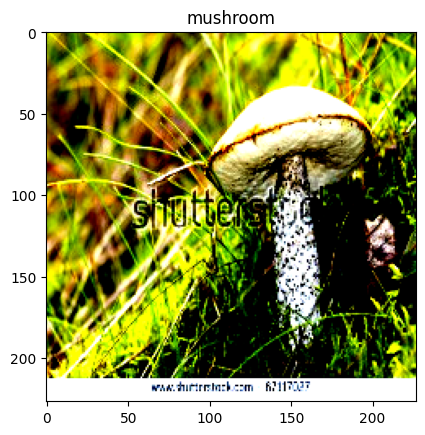

In [ ]:
image, label = validset[21] #(c,h,v) -> (h,w,c)

class_list = ['cucumber', 'eggplant', 'mushroom']

plt.imshow(image.permute(1,2,0))
plt.title(class_list[label]);

In [ ]:
print(f"No. of examples in the trainset {len(trainset)}")
print(f"No. of examples in the validset {len(validset)}")

No. of examples in the trainset 148
No. of examples in the validset 38


# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [ ]:
for images, labels in trainloader:
  break;

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

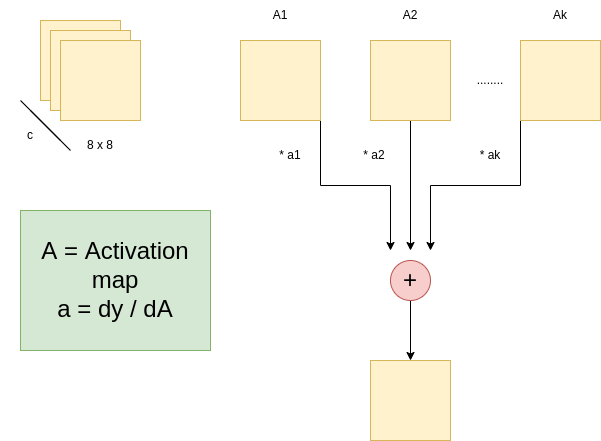

In [ ]:
class ImageModel(nn.Module):

  def __init__(self):
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4,4), stride = 2),

        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4,4), stride = 2),

        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4,4), stride = 2),

        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),

    )

    self.maxpool = nn.MaxPool2d(kernel_size= (4,4), stride = 2)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400, 2048),
        nn.ReLU(),
        nn.Linear(2048, 3)
    )

    self.gradient = None

  def activations_hook(self, grad):
      self.gradient = grad



  def forward(self, images):

    x=self.feature_extractor(images) #activation_maps

    h = x.register_hook(self.activations_hook)
    x = self.maxpool(x)
    x = self.classifier(x)

    return x

  def get_activation_gradients(self): #a1, a2, a3... ak
    return self.gradient

  def get_activation(self, x):#A1, A2, A3... Ak
    return self.feature_extractor(x) #64 * 8 * 8


In [ ]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [ ]:
def train_fn(dataloader, model, optimizer, criterion):

  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def eval_fn(dataloader, model, criterion):

  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    logits = model(images)
    loss = criterion(logits, labels)

    total_loss += loss.item()

  return total_loss / len(dataloader)

# Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_weights.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")

  print(f"EPOCH : {i + 1} TRAIN LOSS : {train_loss} VALID LOSS : {valid_loss}")

100%|██████████| 3/3 [00:00<00:00, 26.52it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 1 TRAIN LOSS : 1.0983576893806457 VALID LOSS : 1.0994057655334473


100%|██████████| 3/3 [00:00<00:00, 30.67it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 2 TRAIN LOSS : 1.044461452960968 VALID LOSS : 0.9994246363639832


100%|██████████| 3/3 [00:00<00:00, 33.81it/s]


EPOCH : 3 TRAIN LOSS : 0.9836305201053619 VALID LOSS : 1.009002725283305


100%|██████████| 3/3 [00:00<00:00, 30.13it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 4 TRAIN LOSS : 0.8693476140499115 VALID LOSS : 0.8696193893750509


100%|██████████| 3/3 [00:00<00:00, 30.65it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 5 TRAIN LOSS : 0.7862344801425933 VALID LOSS : 0.839439849058787


100%|██████████| 3/3 [00:00<00:00, 32.40it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 6 TRAIN LOSS : 0.6422462463378906 VALID LOSS : 0.7894073526064554


100%|██████████| 3/3 [00:00<00:00, 32.14it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 7 TRAIN LOSS : 0.6204264879226684 VALID LOSS : 0.6854386727015177


100%|██████████| 3/3 [00:00<00:00, 28.61it/s]


EPOCH : 8 TRAIN LOSS : 0.6799363374710083 VALID LOSS : 0.953012228012085


100%|██████████| 3/3 [00:00<00:00, 20.70it/s]


EPOCH : 9 TRAIN LOSS : 0.5145156651735305 VALID LOSS : 0.7670876979827881


100%|██████████| 3/3 [00:00<00:00, 20.70it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 10 TRAIN LOSS : 0.5044668048620224 VALID LOSS : 0.497379203637441


100%|██████████| 3/3 [00:00<00:00, 30.54it/s]


EPOCH : 11 TRAIN LOSS : 0.4090558379888535 VALID LOSS : 0.6031538049379984


100%|██████████| 3/3 [00:00<00:00, 27.80it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 12 TRAIN LOSS : 0.33654755204916 VALID LOSS : 0.4099603568514188


100%|██████████| 3/3 [00:00<00:00, 30.54it/s]


EPOCH : 13 TRAIN LOSS : 0.42387463748455045 VALID LOSS : 0.45806392033894855


100%|██████████| 3/3 [00:00<00:00, 31.27it/s]


EPOCH : 14 TRAIN LOSS : 0.4335478439927101 VALID LOSS : 0.41421380639076233


100%|██████████| 3/3 [00:00<00:00, 30.23it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 15 TRAIN LOSS : 0.28466727305203676 VALID LOSS : 0.36690136541922885


100%|██████████| 3/3 [00:00<00:00, 34.25it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 16 TRAIN LOSS : 0.14059042762964963 VALID LOSS : 0.3664715550839901


100%|██████████| 3/3 [00:00<00:00, 28.65it/s]


EPOCH : 17 TRAIN LOSS : 0.1853937590494752 VALID LOSS : 0.5727216899394989


100%|██████████| 3/3 [00:00<00:00, 32.23it/s]


EPOCH : 18 TRAIN LOSS : 0.4253461346030235 VALID LOSS : 0.7400517563025156


100%|██████████| 3/3 [00:00<00:00, 30.13it/s]


EPOCH : 19 TRAIN LOSS : 0.36195417270064356 VALID LOSS : 0.9542682568232218


100%|██████████| 3/3 [00:00<00:00, 28.99it/s]

EPOCH : 20 TRAIN LOSS : 0.412086421251297 VALID LOSS : 0.48280195395151776


# Get GradCAM

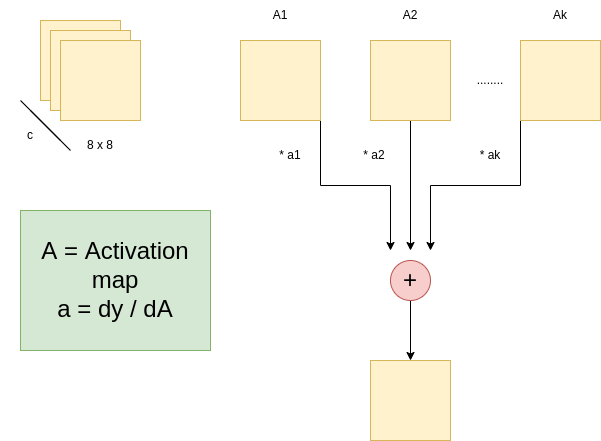

In [ ]:
def get_gradcam(model, image, label, size):

  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim = [0, 2, 3]) #a1, a2,..., ak
  activations = model.get_activation(image).detach() #A1, A2,.., Ak

  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim = 1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size,size))

  return heatmap

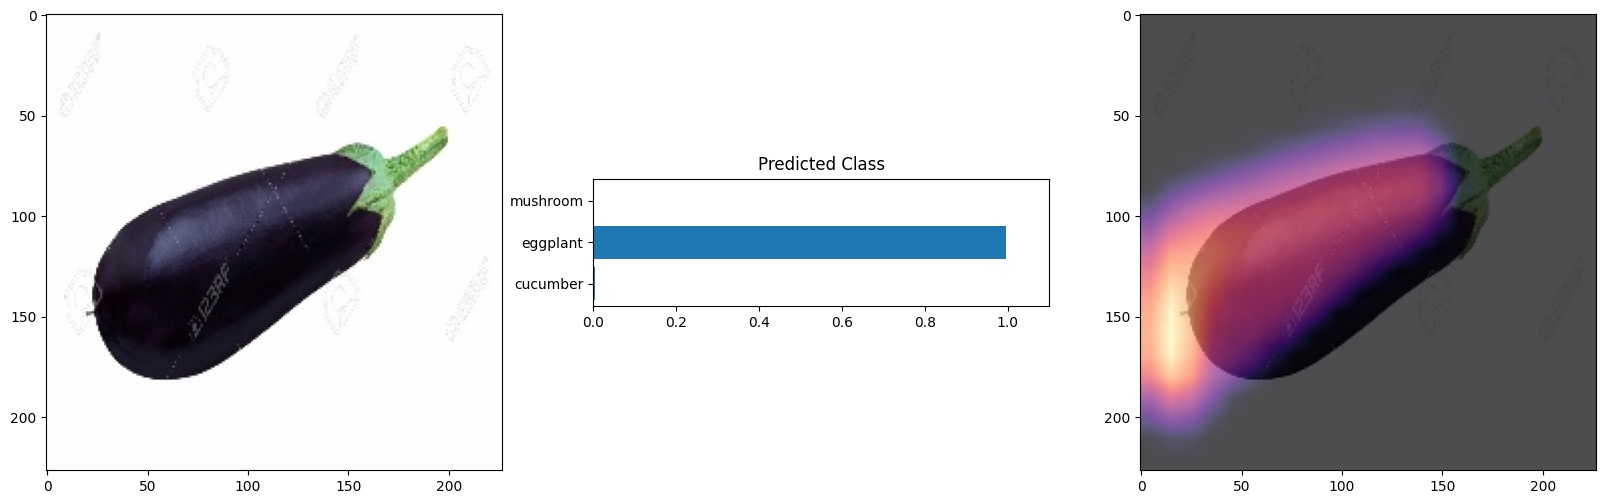

In [ ]:
image, label = validset[4]

denorm_image = image.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

image = image.unsqueeze(0).to(DEVICE)

# cucumber - 0, eggplant - 1, mushroom - 2
pred = model(image)
heatmap = get_gradcam(model, image, pred[0][1], size = 227)
utils.plot_heatmap(denorm_image, pred, heatmap)